### 가치 평가 클래스

In [1]:
#
# DX Library Valuation
# valuation_mcs_european.py
#

import numpy as np
from valuation_class import valuation_class

class valuation_mcs_european(valuation_class):
    '''
    단일 요인 몬테카를로 시뮬레이션을 사용한 임의의 페이오프에 대한
    유러피언 옵션 가치 평가
    
    method
    ----
    generate_payoff:
        주어진 경로, payoff func이용
    present_value:
        몬테카를로 방식으로 추정한 현재 가치 반환
    '''
    def generate_payoff(self,fixed_seed = False):
        '''
        인수
        ====
        fixed_seed : Boolean
            가치 계산 용 시드 값을 중복 사용
        '''
        try :
            #행사가 확인
            strike = self.strike
        except :
            pass
        paths = self.underlying.get_instrument_values(fixed_seed = fixed_seed)
        time_grid = self.underlying.time_grid
        
        try :
            time_index = np.where(time_grid == self.maturity)[0]
            time_index = int(time_index)
        except :
            print('Maturity date not in time grid of underlying')
            
        maturity_value = paths[time_index]
        #전체 경로에 대한 평균
        mean_value = np.mean(paths[:time_index],axis = 1)
        #최댓값
        max_value = np.amax(paths[:time_index],axis = 1)[-1]
        # 최소값
        min_value = np.amin(paths[:time_index],axis = 1)[-1]
        try :
            payoff = eval(self.payoff_func)
            return payoff
        except :
            print('Error evaluating payoff func')
            
    def present_value(self, accuracy =  6, fixed_seed = False, full = False):
        '''
        인수
        ====
        accuracy : int
            반환값 자리수
        fixed_seed : Boolean
            가치 계산용 시드 값 중복 사용
        full : Boolean
            현재 값에 대한 1차원 배열 반환
        '''
        cash_flow = self.generate_payoff(fixed_seed = fixed_seed)
        discount_factor = self.discount_curve.get_discount_factors((self.pricing_date,self.maturity))[0,1]
        result = discount_factor*np.sum(cash_flow)/len(cash_flow)
        if full:
            return round(result, accuracy), discount_factor * cash_flow
        else:
            return round(result, accuracy)

**ex**

In [2]:
from dx import *

In [3]:
me_gbm = market_environment('me_gbm', dt.datetime(2015, 1, 1))

In [4]:
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

In [5]:
csr = constant_short_rate('csr', 0.06)

In [6]:
me_gbm.add_curve('discount_curve', csr)

In [7]:
gbm = geometric_brownian_motion('gbm', me_gbm)

In [8]:
me_call = market_environment('me_call', me_gbm.pricing_date)

In [9]:
me_call.add_constant('strike', 40.)
me_call.add_constant('maturity', dt.datetime(2015, 12, 31))
me_call.add_constant('currency', 'EUR')

In [10]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'

In [11]:
eur_call = valuation_mcs_european('eur_call', underlying=gbm, mar_env=me_call, payoff_func=payoff_func)

In [12]:
%time eur_call.present_value()

Wall time: 8.98 ms


2.277239

In [13]:
%time eur_call.delta()

Wall time: 7.98 ms


0.5403

In [14]:
%time eur_call.vega()

Wall time: 12 ms


15.1587

In [15]:
%%time
s_list = np.arange(34.,46.1,2.)
p_list = []; d_list = []; v_list = []
for s in s_list:
    eur_call.update(initial_value = s)
    p_list.append(eur_call.present_value(fixed_seed=True))
    d_list.append(eur_call.delta())
    v_list.append(eur_call.vega())

Wall time: 171 ms


통계치 그리기 위한 보조 함수

In [16]:
#
# DX Library Valuation
# plot_option_stats.py
#

import matplotlib.pyplot as plt

def plot_option_stats(s_list, p_list, d_list, v_list):
    ''' 
    여러가지 기초자산에 대해 옵션 가격, 델타, 베가 플롯
    Parameters
    ==========
    s_list : array or list
        기초자산 값 집합
    p_list : array or list
        현재 가치
    d_list : array or list
        델타 계산 결과
    v_list : array or list
        베가 계산 결과
    '''
    plt.figure(figsize=(9, 7))
    
    sub1 = plt.subplot(311)
    
    plt.plot(s_list, p_list, 'ro', label='present value')
    plt.plot(s_list, p_list, 'b')
    plt.grid(True); plt.legend(loc=0)
    plt.setp(sub1.get_xticklabels(), visible=False)
    
    sub2 = plt.subplot(312)
    
    plt.plot(s_list, d_list, 'go', label='Delta')
    plt.plot(s_list, d_list, 'b')
    plt.grid(True); plt.legend(loc=0)
    plt.ylim(min(d_list) - 0.1, max(d_list) + 0.1)
    plt.setp(sub2.get_xticklabels(), visible=False)
    
    sub3 = plt.subplot(313)
    
    plt.plot(s_list, v_list, 'yo', label='Vega')
    plt.plot(s_list, v_list, 'b')
    plt.xlabel('initial value of underlying')
    plt.grid(True); plt.legend(loc=0)

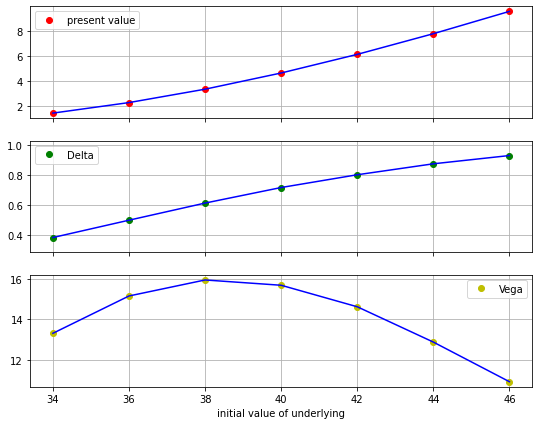

In [17]:
%matplotlib inline
plot_option_stats(s_list,p_list,d_list,v_list)